In [1]:
#= Krussel-Smith using sequence-space Jacobian.

Code will have three parts:

(a) Decompose model into blocks. Same as KS example in Auclert et al., but with endogenous labour supply.

(b) Finding steady-state values of KS (no calibration). Need to translate ks_ss into julia and add labour supply choice.

(c) Accumulating Jacobians. In principle straightforward once we have done everything else. Need to get 300x300 matrices
Jacobians of each output with respect to each input. For example: in firm block, need matrix of how "w" and "r" change
with respect to "Z", "K", and "L". Store these in dictionary.

Extra: depending on how things go, can add calibration step, estimation step, or non-linear dynamics. For more complicated
models, can supply jacobian of "hetblock" to SHADE code directly in dictionary form and let their code do the accumulation
automatically.

Can use parameters from Krussel-Smith parameters in code. Other parameter would be elasticity "v" and disutility "ϕ" of labour.
Can use something reasonable.

=#

#TODOs

## have interpolation routines in-house (interest rate is sensitive to type of interpolation method used).

## 1. Defining parameters

Here we define the parameter struct that will be passed to all subsequent functions. We also use the rowenhorst method to discretize the income process and construct asset grids. All parameters here are identical to those chosen by Auclert et al., in their IPYNB file "krussel-smith" (available on their Github page).


In [2]:
#Parameter struct

using Parameters
using LinearAlgebra
using Dierckx #interpolation routines written in Fortran
using NLsolve
using Roots
using Plots


@with_kw mutable struct Param
    apoints::Int = 500 #asset grid
    amax::Float64 = 200  #asset max
    beta::Float64 = 0.9819527880123726 #discount factor
    alpha::Float64 = 0.11 #capital share
    deprec::Float64 = 0.025 #depreciation rate
    gamma::Float64 = 1 #elasticity of substitution
    rho::Float64 = 0.966  #autocorr of income process
    num_states::Int = 7 #number of states for income process
    sd::Float64 = 0.5 #stand. dev. of deviation process
    mean::Float64 = 0 #mean of income process
    uncond_sd::Float64 = 0.5 # unconditional sd
    y_grid::Array{Float64} = zeros() # grid for income process
    P_trans::Array{Float64} = zeros() # transition matrix
    bc::Int = 0 #borrowing constraint
    # frisch::Float64 = 2/3 #elasticity of labour wrt wages
    Amat::Array{Float64} = zeros() #asset grid
    Ymat::Array{Float64}= zeros() #income grid
    # phi::Float64 = 1 #constant in front of disutility of labour
end
  
param = Param()


Param
  apoints: Int64 500
  amax: Float64 200.0
  beta: Float64 0.9819527880123726
  alpha: Float64 0.11
  deprec: Float64 0.025
  gamma: Float64 1.0
  rho: Float64 0.966
  num_states: Int64 7
  sd: Float64 0.5
  mean: Float64 0.0
  uncond_sd: Float64 0.5
  y_grid: Array{Float64}(()) fill(0.0)
  P_trans: Array{Float64}(()) fill(0.0)
  bc: Int64 0
  Amat: Array{Float64}(()) fill(0.0)
  Ymat: Array{Float64}(()) fill(0.0)


In [3]:
#rowenhort's method to approximate AR(1) w Markov chain
#also constructs asset grids and updates param

function rowenhorst!(param::Param)
    rho, sd, num_states, mean = param.rho, param.uncond_sd, param.num_states, param.mean
    bc, apoints, amax = param.bc, param.apoints, param.amax
    
    #construct grids
    step_r = sd*sqrt(num_states-1)
    y_grid = -1:2/(num_states-1):1
    y_grid = mean .+ step_r*y_grid
    
    #transition matrix 
    
    p = (rho+1)/2
    q = p
    
    P_trans = [p 1-p; 1-q q] 
    
    for i = 2:num_states -1
        a1 = [P_trans zeros(i, 1); zeros(1, i+1)] 
        a2 = [zeros(i,1) P_trans; zeros(1, i+1)]
        a3 = [zeros(1, i+1); P_trans zeros(i,1)]
        a4 = [zeros(1, i+1); zeros(i,1) P_trans]
        
        P_trans = p*a1 + (1-p)*a2 + (1-q)*a3 + q*a4
        P_trans[2:i, :] = P_trans[2:i, :]/2
    end
    
    
    for i=1:num_states
       P_trans[i,:] = P_trans[i,:]/sum(P_trans[i,:])
    end
    
    #get stationary distribution to normalize effective labour to L=1
    pi = eigvecs(P_trans')[:,num_states]
    
    #normalize pi
    pi = pi./sum(pi)
    
    #exponentiate
    y_grid = exp.(y_grid)
    
    #normalize
    y_grid = y_grid/sum(pi.*y_grid)
    
    param.y_grid = y_grid
    param.P_trans = P_trans
    
    # construct asset grids
    Amat = [i for i in range(bc, length = apoints, stop= amax), j in 1:length(y_grid)]
    Ymat = [j for i=1:apoints, j in y_grid]
    
    param.Amat = Amat
    param.Ymat = Ymat
    
    return param
end

param = rowenhorst!(param)



Param
  apoints: Int64 500
  amax: Float64 200.0
  beta: Float64 0.9819527880123726
  alpha: Float64 0.11
  deprec: Float64 0.025
  gamma: Float64 1.0
  rho: Float64 0.966
  num_states: Int64 7
  sd: Float64 0.5
  mean: Float64 0.0
  uncond_sd: Float64 0.5
  y_grid: Array{Float64}((7,)) [0.2595291268380845, 0.390378674741505, 0.5872000247124883, 0.8832548787421952, 1.3285748433063689, 1.998416489677544, 3.005979291521312]
  P_trans: Array{Float64}((7, 7)) [0.9022379843199956 0.09361981119088468 … 8.374316586000039e-9 2.4137569000000128e-11; 0.015603301865147443 0.9035872016735433 … 4.0355125541400147e-7 1.3957194310000061e-9; … ; 1.3957194310000061e-9 4.0355125541400147e-7 … 0.9035872016735433 0.015603301865147443; 2.4137569000000125e-11 8.374316586000037e-9 … 0.09361981119088467 0.9022379843199955]
  bc: Int64 0
  Amat: Array{Float64}((500, 7)) [0.0 0.0 … 0.0 0.0; 0.40080160320641284 0.40080160320641284 … 0.40080160320641284 0.40080160320641284; … ; 199.59919839679358 199.599198396793

# 2 Function definitions

We use these to iterate on the value function (using EGM), construct transition matrix (Young's method), and get the stationary distribution.

In [4]:
#marginal utilities and their inverses
up(c,gamma) = c.^(-gamma)
invup(x,gamma) = x.^(-1/gamma)

#vp(h) = param.phi.*h.^(1/param.frisch)
#invvp(x) = (x./param.phi).^(param.frisch)
    
#define optimal labour supply
    
# function h_opt(c_curr,Ymat,w)
#    u_c = up(c_curr)
#    return invvp(u_c.*Ymat.*w)
# end

#define euler equation iteration
function c_curr(gamma,beta,P_trans;r_future,c_next)
    return invup(beta.*(1+r_future).*up(c_next,gamma)*P_trans',gamma)
end

#obtain current assets given consumption today defined on asset grid tomorrow
function a_curr(;r_curr,w,c_curr,Amat,Ymat)
    return 1/(1+r_curr).*(c_curr.+Amat.-w.*Ymat)
end

#find c at borrowing constraint 

# function c_binding(r,w,Amat,Ymat,bc)
    
#     #initial guess
    
#     c_guess = Amat.+Ymat.*w
    
#     #variable to be returned
    
#     c_bind = similar(Amat)
    
#     for i=1: length(Amat[1,:])
#         for j = 1:length(Amat[:,1])

#          g(c) = (1+r)*Amat[j,i] .+ Ymat[j,i].*w .- c .+bc
    
#         c_bind[j,i] = find_zero(g, c_guess[j,i])
    
#         end
#     end
    
#     return c_bind
# end

# function get_capitaldis(;apoints::Int,num_states::Int,dist::Array{Float64}) 
#     #input is stationary distribution of dimension apoints*num_states
#     #first apoints elements correspond to mass of 
#     #returns capital distribution (vector of size apoints)
#     capital_dist = zeros(num_states*apoints)
#     for i= 1:param.apoints
#     capital_dist[i]=sum(dist[i:apoints:end]);
#     end
#     return capital_dist
# end

#get total EFFECTIVE labor

# function get_L(;n_policy, apoints,num_states,Ymat,dist)
#     #inputs are apoints x num_states policy matrix (policy function for labour) and dist - a stationary distribution
#     # of dimension apoints*num_states.
#     #output is total effective labour.
#     L = reshape(n_policy, (apoints*num_states,1))
#     L = L.*dist.*reshape(Ymat,(apoints*num_states,1))      
#     L = sum(L)
#     return L      
# end

#get capital of future period i.e. get assets saved in CURRENT period given distribution TODAY
function get_K(;a_policy, dist)
    K= reshape(a_policy, (length(dist),1))
    K= sum(K.*dist)
    return K
end

function get_C(;c_policy, dist)
    C = reshape(c_policy, (length(dist),1)) 
    C = sum(C.*dist)
    return C
end


get_C (generic function with 1 method)

In [5]:
#Note: function takes both current and future interest rates as arguments.

function egm_iterate(param::Param;w::Float64,c_next::Array{Float64},c_bind::Array{Float64},r_curr::Float64,r_future::Float64)
# Inputs: param: param struct
#         w: wage rate
#         c_next: consumption next period
#         c_bind: consumption when borrowing constraint binds (to reduce computations)
#         r_curr: current real interest rate
#         r_future: interest rate in future period
# Returns: c_it: na*ny consumption array
#         a_it: na*ny savings array
    
bc = param.bc
apoints = param.apoints
amax = param.amax
y_grid = param.y_grid
gamma = param.gamma
beta = param.beta
P_trans = param.P_trans
#frisch = param.frisch
Amat = param.Amat
Ymat = param.Ymat
#phi = param.phi

#current policy functions on current grid
c_it = c_curr(gamma,beta,P_trans,r_future=r_future,c_next=c_next)
a_it = a_curr(r_curr=r_curr,w=w,c_curr=c_it,Amat=Amat,Ymat=Ymat)

c_nonbinding = similar(Amat)
    
#get consumption policy function for current grid
for i=1:length(y_grid)
    c_nonbinding[:,i] = Spline1D(a_it[:,i],c_it[:,i],bc="extrapolate",k=1)(Amat[:,i])
end

#update elements for which borrowing constraint does bind
for j = 1:length(y_grid)
   c_it[:,j] = (Amat[:,j].>a_it[1,j]).*c_nonbinding[:,j] .+ (Amat[:,j].<=a_it[1,j]).*c_bind[:,j]
end
    
# return labour function
# h_it = h_opt(c_it,Ymat,w)
    
# return asset function 
a_it = @. (1+r_curr)*Amat + w*Ymat - c_it

return c_it, a_it
    
end

# let
    
# r = -1.0
# w=1.0
    
# Amat = param.Amat
# Ymat = param.Ymat
# bc = param.bc

# c_bind = c_binding(r, w, Amat, Ymat, bc)
# c_next = @. r*Amat + w

# _, a = egm_iterate(param,c_bind = c_bind, c_next = c_next, r_future = r, r_curr =r,w=w)

# a
    
# end

egm_iterate (generic function with 1 method)

In [6]:
#define transition function using Young's method


function get_trans(param::Param; policyfun::Array{Float64})
# Inputs: param: param struct
#         policyfun: savings function, array na*ny
# Returns: transition matrix: na*ny, na*ny

#some parameters
Amat = param.Amat
num_states = param.num_states
apoints = param.apoints
P_trans = param.P_trans
    
#construct transition matrix without labour stochasticity
Q = zeros(apoints, apoints, num_states)
    
#finds which element to interpolate to
findnearest(A::AbstractArray,t) = findmin(abs.(A.-t))[2]

next = similar(Amat)
previous = similar(Amat)

for j=1:num_states
for k = 1:apoints
    
ind = findnearest(Amat[:,j],policyfun[k,j])
    
if policyfun[k,j] - Amat[ind,j] >0
    previous[k,j] = Amat[ind,j]
    if ind==apoints
        next[k,j] = Amat[ind,j]
    else         
     next[k,j] = Amat[ind+1,j]
    end
            
elseif policyfun[k,j] == Amat[ind,j]
    previous[k,j]=policyfun[k,j] 
    next[k,j] = policyfun[k,]
            
else
    next[k,j] = Amat[ind,j]
    if ind==1
        previous[k,j] = Amat[ind,j]
    else
        previous[k,j] = Amat[ind-1,j]
    end
    
end  
end
end

for k = 1:apoints
    for j = 1:num_states
        if next[k,j] == previous[k,j]
            Q[Amat[:,1].==previous[k,j],k,j] .= 1
        else
            Q[Amat[:,1].==previous[k,j],k,j] .= (next[k,j]-policyfun[k,j])./(next[k,j]-previous[k,j])
            Q[Amat[:,1].==next[k,j],k,j] .= 1 - (next[k,j]-policyfun[k,j])./(next[k,j]-previous[k,j])
    
        end
    end
end

#construct matrix with labour stochasticity

young_trans = zeros(apoints*num_states,apoints*num_states)

for j=1:num_states
for i=1:num_states
young_trans[(i-1)*apoints+1:i*apoints,(j-1)*apoints+1:j*apoints]=Q[:,:,j].*P_trans[j,i];
end
end

young_trans = young_trans'

return young_trans
    
end

#Tr = get_trans(param,policyfun=policyfun)


get_trans (generic function with 1 method)

In [7]:
# get the same results as auclert et al. if we relax tolerance to 1e-6


function get_stat(param::Param;r, w, tol=1e-8, max_iter=1000)
# Inputs: param: param struct
#         r: steady-state interest rate
#         w: steady-state wage rate
# Returns: K: aggregate capital
#          c_it: consumption function, array
#          init: steady-state distribution vector na*ny
#          a_it: savings function, array
    num_states = param.num_states
    apoints = param.apoints
    Amat = param.Amat
    Ymat = param.Ymat
    bc = param.bc
    
    #initial guess for policy function iteration  
    c_next = @. r*param.Amat+param.Ymat*w
    
    #get binding consumption
    c_bind = @. (1+r)*Amat + w*Ymat + bc
    
    #initial counters
    dist1=1
    iter=1
    
    while dist1>tol && iter<max_iter
        c_it,_ = egm_iterate(param, w=w, r_curr=r, r_future = r, c_next=c_next, c_bind=c_bind)
        dist1 = norm(c_it - c_next, Inf)
        c_next = c_it
        iter = iter+1
    end
    
    #get policy functions after convergence
    c_it,a_it = egm_iterate(param, w=w, r_curr=r,r_future=r, c_next = c_next,c_bind=c_bind)
    
    #initial guess for transition iteration
    init = ones(apoints*num_states)
    init = init./sum(init)
    
    #iterate
    trans = get_trans(param,policyfun=a_it)
    
    #initial counters
    dist2 = 1
    iter=1
    
    while dist2>tol/100 && iter< max_iter
        next_init = (init'*trans)'
        dist2 = norm(next_init - init,Inf)
        init = next_init
        iter = iter+1   
    end
    
    #construct total effective labour
    # L = get_L(n_policy = h_it, apoints=apoints, num_states=num_states,Ymat=Ymat,dist=init)
    
    #construct total assets
    K = get_K(a_policy = a_it, dist = init)
    
    return  K, c_it, init, a_it
    
end



# let
    
# alpha = param.alpha
# deprec = param.deprec

    
# r=0.01
    
# Z = ((r + deprec)/alpha)^alpha
    
# w = (1-alpha)*Z*(alpha*Z/(r+deprec))^(alpha/(1-alpha))

# _,c_it,_,a_it = get_stat(param,r=r,w=w)

# c_it[1,:]
    
# end

#get the same results as auclert et al. if we relax tolerance to
# 1e-6

get_stat (generic function with 1 method)

# 3 Getting the steady-state

We use the previous functions to get the steady-state interest rate that clears the capital markets. Our results are very similar to those of Auclert et al., but the steady-state interest rate differs by about 25 basis points. This is because we have a stricter tolerance for convergence than Auclert et al. for the consumption policy function (1e-8). If we relax the tolerance to (1e-6), we get a steady-state interest rate very close to one, which is what $\beta$ is calibrated to target (in their example).

In [8]:
function hh_ss!(param::Param;r_guess = 0.01,max_iter=100,tol=1e-6)
#returns:
#         rss: steady state interest rate
#         K: aggregate capital
#         css: steady state consumption function
#         policyfun: steady state savings function
            
    alpha = param.alpha
    deprec = param.deprec
    dist = 1
    iter=1
    
    while dist>tol && iter<max_iter
    if r_guess>=1/(param.beta)-1
        error("r too large for convergence")
    end
    
    Z = ((r_guess + deprec)/alpha)^alpha #normalize so Y=1
    w = (1-alpha)*Z*(alpha*Z/(r_guess+deprec))^(alpha/(1-alpha))
        
    K,_ = get_stat(param,r=r_guess,w=w)
    r_supply = Z*alpha*(1/K)^(1-alpha) - deprec
        
    dist = abs(r_guess-r_supply)
    r_guess= 0.9*r_guess+0.1*r_supply
    iter = iter +1
    end
    
    #get final results
    Z = ((r_guess + deprec)/alpha)^alpha
    w = (1-alpha)*Z*(alpha*Z/(r_guess+deprec))^(alpha/(1-alpha))
    
    K,c_ss,init,policyfun = get_stat(param,r=r_guess,w=w)
    
    #check Walras' Law
    if abs(Z*K^alpha - get_C(c_policy = c_ss, dist = init) - deprec*K)>1e-6
        error("Walras' Law does not hold!")
    end
    
    return r_guess,K,c_ss,init,policyfun
end

#get steady-state for jacobian later

# @time rss, Kss, css, dis, policyfun = hh_ss!(param)


hh_ss! (generic function with 1 method)

In [9]:
@time rss, Kss, css, dis, policyfun = hh_ss!(param)

 37.362428 seconds (10.89 M allocations: 7.792 GiB, 5.70% gc time)


(0.009746491334704123, 3.1658017547217208, [0.23098092288589517 0.3474370205199394 … 1.340068504787737 1.6826476260237793; 0.2996886743680945 0.415457127103106 … 1.354374856765323 1.694035689292705; … ; 4.768269440097518 4.852318954141591 … 5.448828094528708 5.712718831797029; 4.775831895012205 4.859878671183931 … 5.456366689995557 5.720248724626005], [0.013257656665112482, 0.0008670331017158481, 0.00038209097564738035, 0.00023700820387429085, 0.0001645732715197935, 0.00012172504245588003, 9.380321480254826e-5, 7.44061179526485e-5, 6.029529669873112e-5, 4.966565114569492e-5  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0 0.0 … 0.43852217102527713 0.9926739434301881; 0.3360002610768003 0.336687905975833 … 0.8289238316066907 1.3859938927202617; … ; 197.00730173717017 197.03970832076016 … 197.8743528356661 198.50719299203874; 197.4044472948145 197.43685661627683 … 198.27152225275827 198.90437111176877])

## Walras' Law
Let us also check walras' law to verify we are doing things right.

In [10]:
#check walras law

let
deprec = param.deprec
alpha = param.alpha
Z = ((rss + deprec)/alpha)^alpha
Z*Kss^alpha - get_C(c_policy = css, dist = dis) - deprec*Kss
end


-3.3458218695603392e-9

# Getting the heterogeneous agent Jacobian matrix

These are functions needed to get the het-agent Jacobian matrix.

In [11]:

function expect_vec(param, policyfun, T; output)
    # inputs
    #    policyfunction: savings function (to construct transition matrix), array
    #    output vector: outputs (capital or consumption or labour, if there is any labour choice) with which transition matrix is multiplied.
    # outputs
    #    expectation vectors
    
    expv = Array{Array{Float64,1},1}(undef,T-1)

    trans= get_trans(param, policyfun = policyfun)
    vec = reshape(output, length(trans[:,1]))
    
    expv[1] = vec
    
    for i=2:T-1
       expv[i] = (trans)*expv[i-1]
    end
    
    return expv
end

function fake_news(T;expv::Array{Array{Float64,1},1},dD::Array{Array{Float64,1},1}, dY::Array{Float64,1})
    #constructs fake news matrix
    #inputs
#         expv: vector of expectation vectors
#         dD: vector of change in distribution (vector of vectors again)
#         dY: changes in outputs, vector of floats
   
    F = zeros(T,T)
    
    for j=1:T
        for i=1:T
            if i == 1
                F[i,j] = dY[j]
            else
                F[i,j] = expv[i-1]'*dD[j]
            end
        end
    end
    
    return F
end

function get_jac(F::Array{Float64})
    #constructs Jacobian
   J = copy(F)
    for j = 2:length(F[:,1])
        for i = 2:length(F[1,:])
            J[i,j] = J[i-1,j-1] + F[i,j]
        end
    end
    
    return J
end


get_jac (generic function with 1 method)

In [12]:
#getting jacobian with respect to r

function get_dYr(param; T, diff, rss::Float64, css::Array{Float64}, dis::Vector{Float64})
# inputs:
#    T: time frame for backwards iteration
#    diff: finite difference step range
#    rss: equilibrium interest rate
#    css: equilbrium consumption (this is what is iterated)
#    dis: a*y steady-state distribution (vector)
# returns
#    dY_0,s of chosen outputs (here, consumption and capital)
#    dD, changes in steady-state distribution due to fake-news shocks, vector of vectors

alpha = param.alpha
deprec = param.deprec
Amat = param.Amat
Ymat = param.Ymat
bc = param.bc
apoints = param.apoints
num_states = param.num_states
    
r_up = rss + diff
r_down = rss - diff
    
Z = ((rss + deprec)/alpha)^alpha
w = (1-alpha)*Z*(alpha*Z/(rss+deprec))^(alpha/(1-alpha)) #keep w constant (partial Jacobian)
    
#vector that holds aggregate differences

dK = zeros(T)
dC = zeros(T)
    
# vector of one-dimensional vectors (must be column vectors!) to hold change in distributions
    
dD = Array{Array{Float64,1},1}(undef,T)
    
#first upward iteration
c_bind = @. (1+r_up)*Amat + w*Ymat + bc
cup,aup = egm_iterate(param, w = w, c_next = css, c_bind = c_bind, r_curr = r_up, r_future = rss)

Λ_up = get_trans(param, policyfun = aup) #get transition function (up)

#first downward iteration
c_bind = @. (1+r_down)*Amat + w*Ymat + bc    
cdown,adown = egm_iterate(param, w = w, c_next = css, c_bind = c_bind, r_curr = r_down, r_future = rss)
    
Λ_down = get_trans(param, policyfun = adown) #get transition function (down)

#get capital and consumption
dK[1] = get_K(a_policy=(aup.-adown)./2, dist=dis)
dC[1] = get_C(c_policy = (cup.-cdown)./2, dist = dis)

#get change in distribution
dD[1] = (dis'*((Λ_up .- Λ_down)./2))'
    
#second upward iteration 
c_bind = @. (1+rss)*Amat + w*Ymat + bc
cup,aup = egm_iterate(param, w = w, c_next = cup, c_bind = c_bind, r_curr = rss, r_future = r_up)
    
Λ_up = get_trans(param, policyfun = aup) #get transition function (up)

#second downward iteration
c_bind = @. (1+rss)*Amat + w*Ymat + bc
cdown,adown = egm_iterate(param, w = w, c_next = cdown, c_bind = c_bind, r_curr = rss, r_future = r_down)
    
Λ_down = get_trans(param, policyfun = adown) #get transition function (down)
    
#get capital and consumption
dK[2] = get_K(a_policy=(aup.-adown)./2, dist=dis)
dC[2] = get_C(c_policy = (cup.-cdown)./2, dist = dis)

#change in distribution
dD[2] = (dis'*((Λ_up .- Λ_down)./2))'

for i=1:T-2
    #upward iteration
    cup,aup = egm_iterate(param, w = w, c_next = cup, c_bind = c_bind, r_curr = rss, r_future = rss)
    Λ_up = get_trans(param, policyfun = aup)
    
    #downward iteration
    cdown,adown = egm_iterate(param, w = w, c_next = cdown, c_bind = c_bind, r_curr = rss, r_future = rss)
    Λ_down = get_trans(param, policyfun = adown) #get transition function (down)
    
    #get capital, consumption, and distribution
    dK[i+2] = get_K(a_policy=(aup.-adown)./2, dist=dis)
    dC[i+2] = get_C(c_policy = (cup.-cdown)./2, dist = dis)
    dD[i+2] = (dis'*((Λ_up .- Λ_down)./2))'
end     
    
    return dK./diff, dC./diff, dD./diff

end


get_dYr (generic function with 1 method)

In [13]:
#getting jacobian with respect to w

function get_dYw(param; T, diff, rss::Float64, css::Array{Float64}, dis::Vector{Float64})
#similar to get_dYr

alpha = param.alpha
deprec = param.deprec
Amat = param.Amat
Ymat = param.Ymat
bc = param.bc
apoints = param.apoints
num_states = param.num_states
    
r = rss
    
Z = ((rss + deprec)/alpha)^alpha
w = (1-alpha)*Z*(alpha*Z/(rss+deprec))^(alpha/(1-alpha)) #keep w constant (partial Jacobian)
    
wup = w + diff
wdown = w - diff
    
#vector that holds aggregate differences

dK = zeros(T)
dC = zeros(T)
    
# vector of one-dimensional vectors (must be column vectors!) to hold change in distributions
    
dD = Array{Array{Float64,1},1}(undef,T)
    
#first upward iteration
c_bind = @. (1+r)*Amat + wup*Ymat + bc
cup,aup = egm_iterate(param, w = wup, c_next = css, c_bind = c_bind, r_curr = r, r_future = r)

Λ_up = get_trans(param, policyfun = aup) #get transition function (up)

#first downward iteration
c_bind = @. (1+r)*Amat + wdown*Ymat + bc    
cdown,adown = egm_iterate(param, w = wdown, c_next = css, c_bind = c_bind, r_curr = r, r_future = r)
    
Λ_down = get_trans(param, policyfun = adown) #get transition function (down)

#get capital and consumption
dK[1] = get_K(a_policy=(aup.-adown)./2, dist=dis)
dC[1] = get_C(c_policy = (cup.-cdown)./2, dist = dis)

#get change in distribution
dD[1] = (dis'*((Λ_up .- Λ_down)./2))'
    
#second upward iteration 
c_bind = @. (1+r)*Amat + w*Ymat + bc
cup,aup = egm_iterate(param, w = w, c_next = cup, c_bind = c_bind, r_curr = r, r_future = r)
    
Λ_up = get_trans(param, policyfun = aup) #get transition function (up)

#second downward iteration
c_bind = @. (1+r)*Amat + w*Ymat + bc
cdown,adown = egm_iterate(param, w = w, c_next = cdown, c_bind = c_bind, r_curr = r, r_future = r)
    
Λ_down = get_trans(param, policyfun = adown) #get transition function (down)
    
#get capital and consumption
dK[2] = get_K(a_policy=(aup.-adown)./2, dist=dis)
dC[2] = get_C(c_policy = (cup.-cdown)./2, dist = dis)

#change in distribution
dD[2] = (dis'*((Λ_up .- Λ_down)./2))'

for i=1:T-2
    #upward iteration
    cup,aup = egm_iterate(param, w = w, c_next = cup, c_bind = c_bind, r_curr = r, r_future = r)
    Λ_up = get_trans(param, policyfun = aup)
    
    #downward iteration
    cdown,adown = egm_iterate(param, w = w, c_next = cdown, c_bind = c_bind, r_curr = rss, r_future = rss)
    Λ_down = get_trans(param, policyfun = adown) #get transition function (down)
    
    #get capital, consumption, and distribution
    dK[i+2] = get_K(a_policy=(aup.-adown)./2, dist=dis)
    dC[i+2] = get_C(c_policy = (cup.-cdown)./2, dist = dis)
    dD[i+2] = (dis'*((Λ_up .- Λ_down)./2))'
end     
    
    return dK./diff, dC./diff, dD./diff

end

get_dYw (generic function with 1 method)

In [14]:
function het_jac(param; rss::Float64, css::Array{Float64}, policyfun::Array{Float64}, dis::Vector{Float64}, T=300, diff = 1e-5)
    
    #get dY_0^s and dD_1^s
    dKr, dCr, dDr = get_dYr(param; rss=rss, css=css, dis=dis, T=T, diff=diff)
    dKw, dCw, dDw = get_dYw(param; rss=rss, css=css, dis=dis, T=T, diff=diff)
    
    #get vector of expectation vectors (size T-1)
    expv_a = expect_vec(param, policyfun, T; output = policyfun)
    expv_c = expect_vec(param, policyfun, T; output = css)
    
    #construct fake news matrix
    F_ar = fake_news(T; expv = expv_a, dY = dKr, dD = dDr)
    F_cr = fake_news(T; expv = expv_c, dY = dCr, dD = dDr)
    
    F_aw = fake_news(T; expv = expv_a, dY = dKw, dD = dDw)
    F_cw = fake_news(T; expv = expv_c, dY = dCw, dD = dDw)
    
    #get jacobian
    J_ar = get_jac(F_ar)
    J_cr = get_jac(F_cr)
    
    J_aw = get_jac(F_aw)
    J_cw = get_jac(F_cw)

    #construct dictionaries
    J = Dict()
    
    J_a = Dict("r" => J_ar, "w" => J_aw)
    J_c = Dict("r" => J_cr, "w" => J_cw)
    
    J["A"] = J_a
    J["C"] = J_c
    
    return J
end


het_jac (generic function with 1 method)

## Partial Jacobians

We store the Jacobians as a dictionary, where the first key accesses outputs and the second key accesses outputs. Our results are very similar to those of Auclert et al, for all outputs and all inputs. The only discrepancy arises from the fact that the steady-state interest rate in our setting is 25 basis points lower, which is due to our lower tolerance for convergence (our code has lower numerical error), and the slightly different interpolation schemes employed in the endogenous grid method.

In [15]:
@time J = het_jac(param; rss = rss, css = css, policyfun = policyfun, dis = dis)

J["A"]["r"]

298.800404 seconds (233.79 M allocations: 505.469 GiB, 29.13% gc time)


300×300 Array{Float64,2}:
 3.06539      0.676514     0.637225     …   5.34652e-7   5.09756e-7
 2.99667      3.71589      1.28996          1.08487e-6   1.03436e-6
 2.9293       3.62238      4.30661          1.65162e-6   1.57472e-6
 2.86326      3.53141      4.19141          2.23592e-6   2.13182e-6
 2.79851      3.44289      4.07973          2.83883e-6   2.70665e-6
 2.73503      3.35676      3.97147      …   3.46145e-6   3.30027e-6
 2.67279      3.27291      3.86649          4.10492e-6   3.91378e-6
 2.61177      3.19128      3.76466          4.77043e-6   4.54831e-6
 2.55194      3.11177      3.66586          5.45925e-6   5.20505e-6
 2.49328      3.03432      3.56994          6.17267e-6   5.88526e-6
 2.43577      2.95884      3.4768       …   6.91207e-6   6.59023e-6
 2.37939      2.88526      3.38632          7.67886e-6   7.32132e-6
 2.32411      2.81353      3.29838          8.47455e-6   8.07996e-6
 ⋮                                      ⋱               
 0.000898913  0.0010485    0.0011

# Simple Block Jacobians

We now obtain the Jacobians for simple blocks, such as firms and market clearing conditions, which depend on only a finite number of aggregate state variables.

In [16]:
#define functions

#firm block takes K(-1) as argument as capital stock already determined.
function firm(K, L, Z, alpha, deprec)
    r = alpha * Z * (K / L)^(alpha-1) - deprec
    w = (1 - alpha) * Z * (K / L)^alpha
    Y = Z * K^alpha * L^(1 - alpha)
    return [r, w, Y]
end

function simple_jac(param; Kss, rss, T=300, diff=1e-5)
    deprec = param.deprec
    alpha = param.alpha 
    
    inputs = ["K","Z"]
    outputs = ["r","w","Y"]
    
    Zss = ((rss + deprec)/alpha)^alpha
    Lss = 1.0
    
    Kup = Kss + diff
    Kdown = Kss - diff
    
    Zup = Zss + diff
    Zdown = Zss - diff
    
    K_diff = @. (firm(Kup, Lss, Zss, alpha, deprec) - firm(Kdown, Lss, Zss, alpha, deprec))/(2*(1e-5))
    Z_diff = @. (firm(Kss, Lss, Zup, alpha, deprec) - firm(Kss, Lss, Zdown, alpha, deprec))/(2*(1e-5))
    
    J = Dict()
    J["r"] = Dict()
    J["w"] = Dict()
    J["Y"] = Dict()
    
    for i=1:length(outputs)
       jac = I(T).*K_diff[i]
       jac = vcat(zeros(T)',jac)
       jac = jac[1:T+1 .!= T+1,:]
       J[outputs[i]]["K"] = jac
    end
    
    for i=1:length(outputs)
        jac= I(T).*Z_diff[i]
        J[outputs[i]]["Z"] = jac
    end
   
    return J
    
end




simple_jac (generic function with 1 method)

In [17]:
firm_J = simple_jac(param; Kss = Kss, rss = rss)

Dict{Any,Any} with 3 entries:
  "Y" => Dict{Any,Any}("Z"=>[1.13515 0.0 … 0.0 0.0; 0.0 1.13515 … 0.0 0.0; … ; …
  "w" => Dict{Any,Any}("Z"=>[1.01028 0.0 … 0.0 0.0; 0.0 1.01028 … 0.0 0.0; … ; …
  "r" => Dict{Any,Any}("Z"=>[0.0394423 0.0 … 0.0 0.0; 0.0 0.0394423 … 0.0 0.0; …

# Solving for Unknowns

We can now use the Jacobians we obtained in the previous sections to solve for the unknown endogenous variable "K". As long as the model is locally invertible around the steady-state, we can use the implicit function theorem on the market clearing conditions to solve for all unknown. Clearly, this requires that we have as many market clearing conditions as we have unknowns.

In [18]:
#get general equilibrium Jacobians in terms of the unknown "K" and the exogenous "Z"

G_AK = J["A"]["r"]*firm_J["r"]["K"] + J["A"]["w"]*firm_J["w"]["K"]
G_AZ = J["A"]["r"]*firm_J["r"]["Z"] + J["A"]["w"]*firm_J["w"]["Z"]

#Jacobians for market clearing conditions

H_K = G_AK - I(300)
H_Z = G_AZ

#get Jacobian of unknown "K" using Implicit Function Theorem

G = Dict()
G["K"] = -H_K^(-1)*H_Z


300×300 Array{Float64,2}:
 0.923523    -0.0648924   -0.057292    …  -1.17515e-13   9.98653e-13
 0.840026     0.865136    -0.116501        2.19081e-13   1.14917e-12
 0.764021     0.787504     0.818661       -2.6416e-13    2.33e-12
 0.694869     0.716784     0.745662       -2.97202e-12   2.67134e-12
 0.631972     0.65239      0.679122       -5.15117e-12   8.26304e-13
 0.57478      0.593779     0.618496    …  -6.00889e-12  -3.50146e-13
 0.522784     0.540443     0.56328        -7.6642e-12   -1.46675e-13
 0.475517     0.491916     0.513002       -7.06974e-12  -6.91222e-13
 0.432549     0.44777      0.46723        -6.67052e-12   1.12337e-12
 0.393491     0.40761      0.425565       -5.83208e-12   2.72241e-12
 0.357985     0.371078     0.387639    …  -3.64565e-12   4.8736e-12
 0.325705     0.337843     0.353118       -3.2316e-12    8.44854e-12
 0.296357     0.307608     0.321694       -2.25624e-12   1.03002e-11
 ⋮                                     ⋱                
 5.64254e-9   5.26215e-9

# Accumulating Jacobians

We can now obtain the general equilibrium Jacobians through forward accumulation (this is similar to what automatic differentiation packages do). For more complex models, this is an error-prone approach, but we can easily do so here. We will demonstrate in another notebook how one can obtain the computational intensive heterogenous agent Jacobians in Julia, and then transfer the data to Python to let Auclert et al's code do the accumulation automatically.

In [19]:
#we accumulate forward along the directed acyclic graph.
G["r"] = firm_J["r"]["Z"] + firm_J["r"]["K"]*G["K"]
G["w"] = firm_J["w"]["Z"] + firm_J["w"]["K"]*G["K"]
G["Y"] = firm_J["Y"]["Z"] + firm_J["Y"]["K"]*G["K"]

G["C"] = J["C"]["r"]*G["r"] + J["C"]["w"]*G["w"]

300×300 Array{Float64,2}:
 0.211626     0.0648924    0.057292     …  -1.22168e-13  -2.02549e-12
 0.0924985    0.204489     0.0586509        1.7277e-13   -1.00556e-12
 0.0841922    0.0860643    0.198852         1.04082e-12  -7.67575e-13
 0.0765991    0.0783955    0.0809776        2.40283e-13   7.02017e-14
 0.0696689    0.0713793    0.0738082        1.56929e-12  -7.78581e-13
 0.0633514    0.0649703    0.0672445    …   1.64407e-12   5.01834e-13
 0.0575982    0.0591232    0.0612448        2.17827e-12   4.68017e-13
 0.052363     0.0537941    0.0557674        1.11098e-12   9.51114e-13
 0.0476019    0.0489408    0.0507719        4.13054e-13  -2.05056e-13
 0.0432741    0.0445237    0.0462195       -3.23583e-13  -9.28665e-13
 0.0393414    0.0405053    0.0420735    …  -1.65299e-13  -1.73376e-12
 0.0357685    0.0368509    0.0382994       -9.37895e-13  -1.63998e-12
 0.0325229    0.0335283    0.034865        -4.33416e-13  -2.4803e-12
 ⋮                                      ⋱                
 3.0149

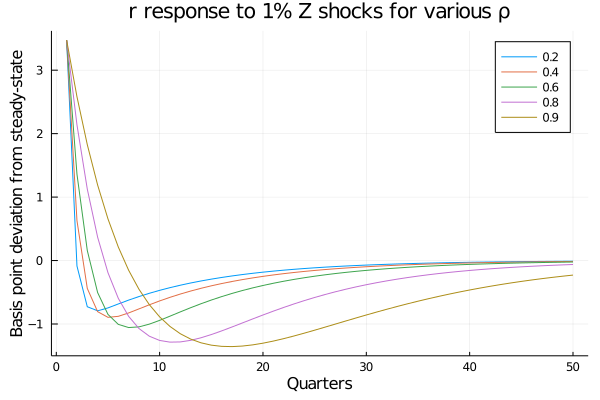

In [20]:
let
    T=300
    deprec = param.deprec
    alpha = param.alpha
   
    Zss = ((rss + deprec)/alpha)^alpha
    rhos = [0.2 0.4 0.6 0.8 0.9]
    
    #get 1% Z shock from steady state
    dZ = 0.01*Zss*rhos.^(0:T-1)
    dr = G["r"]*dZ
    
    plot(10000*dr[1:50,:],label=string.(rhos))
    title!("r response to 1% Z shocks for various ρ")
    xlabel!("Quarters")
    ylabel!("Basis point deviation from steady-state")
end

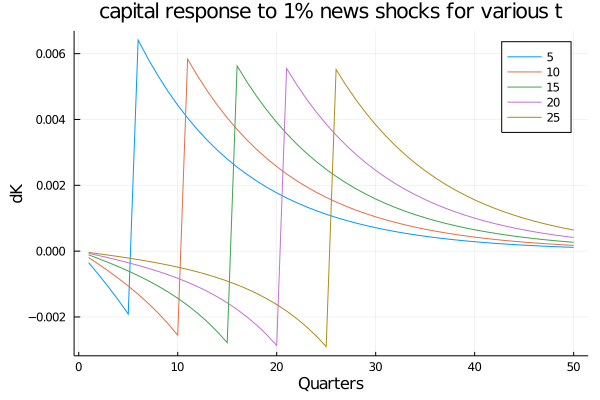

In [21]:
let
    T=300
    deprec = param.deprec
    alpha = param.alpha
   
    Zss = ((rss + deprec)/alpha)^alpha
    t = [5 10 15 20 25]
    
    #get 1% Z shock from steady state
    dZ = 0.01*Zss.*((0:T-1) .== t)
    dK = G["K"]*dZ
    
    plot(dK[1:50,:],label=string.(t))
    title!("capital response to 1% news shocks for various t")
    xlabel!("Quarters")
    ylabel!("dK")
end

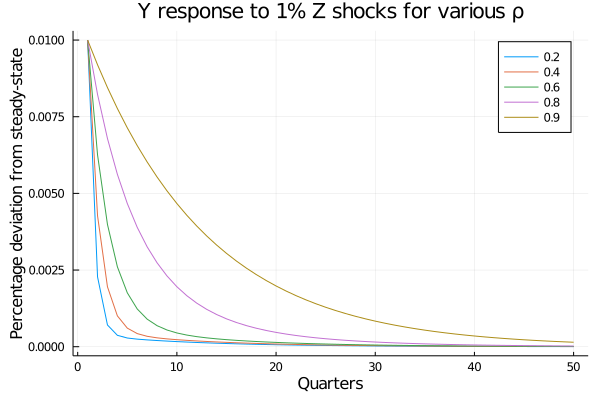

In [22]:
let
    T=300
    deprec = param.deprec
    alpha = param.alpha
    
    Zss = ((rss + deprec)/alpha)^alpha
    Yss = Zss*Kss^alpha
    rhos = [0.2 0.4 0.6 0.8 0.9]
    
    #get 1% Z shock from steady state
    dZ = 0.01*Zss*rhos.^(0:T-1)
    dY = G["Y"]*dZ/Yss
    
    plot(dY[1:50,:],label=string.(rhos))
    title!("Y response to 1% Z shocks for various ρ")
    xlabel!("Quarters")
    ylabel!("Percentage deviation from steady-state")
end